# Lecture 3.1: Clustering

This lecture, we are going to cluster a geospatial dataset using k-Means.

**Learning goals:**

- Explore data using clustering
- Implement k-means
- Visualize geospatial data
- Create a ridgeline graph


We are tasked with gathering insights into to a volcano dataset 🌋, but we know nothing about geology 🙈. No need to panic! We know machine learning algorithms that can help us explore the patterns in this data. 


## 1. Geospatial Data

Let's start our volcanic exploration by loading the dataset into pandas:


In [1]:
import pandas as pd

volcanos = pd.read_csv('volcanos.csv')
volcanos.head()

/Users/amine/.local/share/virtualenvs/practical-data-scientist-umj5maBJ-python/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,Number,Name,Country,Region,Type,Activity Evidence,Last Known Eruption,Latitude,Longitude,Elevation (Meters),Dominant Rock Type,Tectonic Setting
0,210010,West Eifel Volcanic Field,Germany,Mediterranean and Western Asia,Maar(s),Eruption Dated,8300 BCE,50.170,6.85,600,Foidite,Rift Zone / Continental Crust (>25 km)
1,210020,Chaine des Puys,France,Mediterranean and Western Asia,Lava dome(s),Eruption Dated,4040 BCE,45.775,2.97,1464,Basalt / Picro-Basalt,Rift Zone / Continental Crust (>25 km)
2,210030,Olot Volcanic Field,Spain,Mediterranean and Western Asia,Pyroclastic cone(s),Evidence Credible,Unknown,42.170,2.53,893,Trachybasalt / Tephrite Basanite,Intraplate / Continental Crust (>25 km)
3,210040,Calatrava Volcanic Field,Spain,Mediterranean and Western Asia,Pyroclastic cone(s),Eruption Dated,3600 BCE,38.870,-4.02,1117,Basalt / Picro-Basalt,Intraplate / Continental Crust (>25 km)
4,211001,Larderello,Italy,Mediterranean and Western Asia,Explosion crater(s),Eruption Observed,1282 CE,43.250,10.87,500,No Data,Subduction Zone / Continental Crust (>25 km)


There are a lot of columns, but the most interesting are `Latitude` and `Longitude`. These are geospatial coordinates, which means it's our first opportunity to visualize some awesome maps! There are many geospatial data visualization libraries in python, but for this notebook we'll use [folium](https://python-visualization.github.io/folium/). 

Let's focus on the coordinates by selecting the two geospatial columns from our `DataFrame`:

In [2]:
coords = volcanos[['Latitude', 'Longitude']]

We now have to initialize a [`folium.Map`](https://python-visualization.github.io/folium/modules.html#folium.folium.Map). This is done with one central location. Since our coordinates span the entire globe, this doesn't matter, and we can pick our first volcano as center:

In [3]:
import folium
m = folium.Map(location=coords.iloc[0], tiles='Stamen Toner', zoom_start=1)
type(m)

folium.folium.Map

In [4]:
m

We have a map! 🗺 Notice how you can move and zoom interactively. Let's populate this map with our volcanos! We'll iterate through the `DataFrame` rows using [`.iterrows()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html). Then, we can create a [`Circle`](https://python-visualization.github.io/folium/modules.html#folium.vector_layers.Circle) for each volcano location. These have to be explicitly added to the map with `.add_to(m)`:

In [5]:
for index, row in coords.iterrows():
    folium.Circle(
    radius=10,
    location=list(row),
    color='crimson',
    fill=True,
    ).add_to(m)

m

This is already much easier to understand than our tabular format! Notice how volcanos aren't spread around the globe, but instead form "clumps" and "lines". We'd like to investigate this further, but we don't have a column which categorizes the data into these groups... 

## 2. K-Means

So we're going to have to make them ourselves! This is a clustering task, for which we will use the k-Means implementation from the [sklearn](https://scikit-learn.org/) library. Remember that k-Means is a _learning_ algorithm, so there will be two steps: fitting the data, then applying the model on the data.

First let's train our k-Means model. It looks like there is a dozen "clumps" on the map, so we'll pick a somewhat arbitrary $k=10$. Then, we'll convert our `DataFrame` to a NumPy `ndarray` using the [`.to_numpy()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html) method, and fit the model to the data:

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
kmeans.fit(coords.to_numpy())

KMeans(n_clusters=10)

Our model is trained, and ready to be used! Next, we "predict" the cluster allocation of points by feeding our `DataFrame` back into the `kmeans` model. 

ℹ️ This step might sound redundant, but it is important to differentiate between _training data_ and _prediction data_. In our case, they are the same, but they don't have to be! For example, if we were aliens and our dataset contained _billions_ of volcanoes, it could be more efficient to choose a random subset of the data to train the k-Means model.

In [7]:
y_kmeans = kmeans.predict(coords)
y_kmeans

array([7, 7, 7, ..., 8, 4, 4], dtype=int32)

The [`.predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.predict) method returned a vector of integers. These are the _cluster allocations_ of our volcanos. Each cluster is labeled by an integer , and each volcano is assigned a cluster. This vector stores these assignments.

This allows us to visualize the clusters on our map! We use a trick to iterate through the `coords.iterrows()` and the `y_kmeans` at the same time: the python builtin function, [`zip()`](https://docs.python.org/3.3/library/functions.html#zip):

In [8]:
import seaborn as sns

colors = sns.color_palette('husl', n_colors=10).as_hex()

m = folium.Map(location=coords.iloc[0], tiles='Stamen Toner', zoom_start=1)

for (index, row), y in zip(coords.iterrows(), y_kmeans):
    folium.Circle(
    radius=10,
    location=list(row),
    color=colors[y],
    fill=True,
).add_to(m)

m

That's a lava hot visualization 🔥Notice how k-Means identified real underlying patterns in the data, and forms geospatially coherent groups. 

## 3. Cluster Analysis

The clusters _look_ good, but let's see if they can be useful in our data exploration. First, let's append our cluster allocation data to our `DataFrame` as a new column:

In [9]:
volcanos.loc[:, 'Cluster'] = y_kmeans.copy()
volcanos.head() 

,Number,Name,Country,Region,Type,Activity Evidence,Last Known Eruption,Latitude,Longitude,Elevation (Meters),Dominant Rock Type,Tectonic Setting,Cluster
0,210010,West Eifel Volcanic Field,Germany,Mediterranean and Western Asia,Maar(s),Eruption Dated,8300 BCE,50.170,6.85,600,Foidite,Rift Zone / Continental Crust (>25 km),7
1,210020,Chaine des Puys,France,Mediterranean and Western Asia,Lava dome(s),Eruption Dated,4040 BCE,45.775,2.97,1464,Basalt / Picro-Basalt,Rift Zone / Continental Crust (>25 km),7
2,210030,Olot Volcanic Field,Spain,Mediterranean and Western Asia,Pyroclastic cone(s),Evidence Credible,Unknown,42.170,2.53,893,Trachybasalt / Tephrite Basanite,Intraplate / Continental Crust (>25 km),7
3,210040,Calatrava Volcanic Field,Spain,Mediterranean and Western Asia,Pyroclastic cone(s),Eruption Dated,3600 BCE,38.870,-4.02,1117,Basalt / Picro-Basalt,Intraplate / Continental Crust (>25 km),7
4,211001,Larderello,Italy,Mediterranean and Western Asia,Explosion crater(s),Eruption Observed,1282 CE,43.250,10.87,500,No Data,Subduction Zone / Continental Crust (>25 km),7


Manipulating one object will be easier than two! Let's investigate distributional differences between the clusters (see lecture 2.3):

In [10]:
volcanos.groupby('Cluster').mean()

,Number,Latitude,Longitude,Elevation (Meters)
Cluster,,,,
0,223849.875000,11.004615,37.141453,1753.343750
1,346538.178378,10.194103,-86.402016,2135.897297
2,292437.858934,43.716110,147.049762,1234.103448
3,313437.190476,53.428929,-162.409798,1644.630952
4,360911.828402,-35.117982,-67.176225,3539.153846
5,266370.000000,1.013470,114.295304,1580.682028
6,270422.375000,-25.981521,-166.073792,167.583333
7,328848.646341,46.377220,-11.899890,971.658537
8,263201.087719,-20.214614,160.141974,875.491228


Interestingly, the clusters have different `Evelation` averages. This suggests that by identifying volcanos that were close to eachother, k-Means also grouped the data by other criteria of similarity. In lecture 2.6, we learned how averages can be misleading, and that it's preferential to visualise entire _distributions_ of datasets. Let's do this with a [ridgeline plot](https://www.data-to-viz.com/graph/ridgeline.html):

/Users/amine/.local/share/virtualenvs/practical-data-scientist-umj5maBJ-python/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/amine/.local/share/virtualenvs/practical-data-scientist-umj5maBJ-python/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/amine/.local/share/virtualenvs/practical-data-scientist-umj5maBJ-python/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


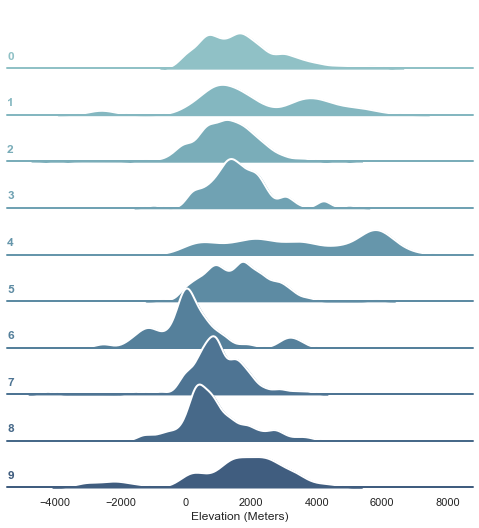

In [11]:
#TO DO study the code of visualisation
import matplotlib.pyplot as plt

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = volcanos[["Elevation (Meters)", 'Cluster']]

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(15, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Cluster", hue="Cluster", aspect=10, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Elevation (Meters)", clip_on=False, shade=True, alpha=1, lw=1.5, bw_method=.2)
g.map(sns.kdeplot, "Elevation (Meters)", clip_on=False, color="w", lw=2, bw_method=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Elevation (Meters)")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.gcf().set_size_inches(8, 8)

This is an example of a more "advanced" [seaborn](https://seaborn.pydata.org/) plot that can be both aesthetic and informative!


## Summary

Today was our introduction to **data analysis**. We learned how **machine learning algorithms** differ from rule-based algorithms, and how they fall into either **supervised learning** and **unsupervised learning**. Then, we explained what **clustering** is, and identified some of its major **applications**. We defined the most popular clustering method: **k-Means**, and visualized the **Expectation-Maximization** optimisation algorithm before giving it a try ourselves. It allowed us to infer structures in a **geospatial** dataset, which gave insights into the distributions of volcanos across the Globe.



# Resources


### Core Resources

- [Python Data Science Handbook - k-Means](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
- [k-Means applications and drawbacks](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a)  
Excellent blog to further your k-Means skills with silhouette analysis and the elbow method

### Additional Resources

- [k-Means clustering from the mathematicalmonk](https://youtu.be/0MQEt10e4NM)  
Detailed but intuitive theoretical explanation of k-Means